## Setup
# CNN Cifar 5

In [1]:
##
## Restrict tensorflow to single GPU
##
import os 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)           
## this says only use GPU 0  (can select 0-3)

##
## Import libraries
##
import evm_flat         ## We are using EVMs for a different project, so there are some things in here that may be confusing
from utils import *     ## utils holds a few functions I wrote to help with the experiments in this notebook
import numpy as np
import tensorflow as tf

##
## Experiment Parameters
##
epochs = 10                 ## Iterations to train CNN for feature extractors
num_to_remove = 5           ## Number of classes to remove and make "unknown"
iterations = 30              ## Number of iterations (full experiments) to run
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]  ## Confidence thresholds to evaluate over

##
## EVM Parameters (good initial values, but could be further optimized)
##
tailsize = 10000              ## EVM tail size
cover_threshold = 0.5      ## EVM cover threshold
dist_func = 'cosine'     ## EVM distance function
num_to_fuse = 4             ## EVM number to fuse
margin_scale = 0.5          ## EVM margin scale

## Data

In [2]:
##
## Load CiFar10
##
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

##
## Get data in correct shape and normalize
##
#x_train = x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))/255.0   ## Add dimension and normalize
#x_test = x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))/255.0         ## Add dimension and normalize
#y_train = tf.keras.utils.to_categorical(y_train)     ## Make one-hot
#y_test = tf.keras.utils.to_categorical(y_test)       ## Make one-hot

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
import keras.utils
y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test) 

## Create Feature Extractor With Perfect Knowledge 

- Feature extractor is a CNN trained using ALL of the classes
- This is not realistic in the real world because all of the classes will not be known
- This is a good "optimal" feature space to compare against
- Goal would be to get as close to this performance as possible

In [5]:
##
## Perfect Knowledge feature extractor
##
perfect = feature_model2(10, x_train, y_train, x_test, y_test)   ## This function is defined in utils.py

313/313 [==============================] - 1s 3ms/step - loss: 0.8331 - accuracy: 0.7051
[0.8331470489501953, 0.7050999999046326]


## Define a set of experiments

- Randomly select and remove classes from the training data
- Split test data into known and unknown classes
- Fit imperfect feature extraction model
- Extract features using the perfect and imperfect extractors
- Fit EVM using features for the perfect and imperfect
- Evaluate performance (evaluation metrics may need to be improved, but this gives us an initial idea of performance)
- Repeat


In [6]:
import pandas as pd
##
## Define places to store results
##
imp_known_correct_all = []
imp_known_novel_all = []
imp_unknown_correct_all = []
imp_unknown_novel_all = []
per_known_correct_all = []
per_known_novel_all = []
per_unknown_correct_all = []
per_unknown_novel_all = []


df = pd.DataFrame(columns=['Iteration', 'Unknown Classes', 'imp_known_correct_all', 'imp_known_novel_all', 'imp_unknown_novel_all','per_known_correct_all','per_known_novel_all','per_unknown_novel_all'])

##
## Begin experiments
##
for i in range(iterations):
    print('Iteration: ' + str(i))
    print()
    
    ##
    ## Split the data into known and unknown classes
    ##
    toRemove = np.random.choice(10, num_to_remove, replace = False)                                         ## Randomly pick unknown classes
    x_train_known, x_train_unknown, y_train_known, y_train_unknown = split_data(x_train, y_train, toRemove) ## Split train data (defined in utils.py)
    x_test_known, x_test_unknown, y_test_known, y_test_unknown = split_data(x_test, y_test, toRemove)       ## Split test data (defined in utils.py)

    print(x_train_known.shape)
    print(y_train_known.shape)
    print(x_test_known.shape)
    print(y_test_known.shape)
    
    ##
    ## Train a classifier based feature extractor using only the known classes
    ##
    #y_train_known = tf.keras.utils.to_categorical(y_train_known) 
    #y_test_known = tf.keras.utils.to_categorical(y_test_known) 
    
    print(x_train_known.shape)
    print(y_train_known.shape)
    print(x_test_known.shape)
    print(y_test_known.shape)
    
    y_train_known = np.squeeze(y_train_known)
    print(y_train_known.shape)
    imperfect = feature_model2(10-num_to_remove, x_train_known, y_train_known, x_test_known, y_test_known, epochs = epochs, batch_size = 32, verbose = 0)

    ##
    ## Extract features with imperfect extractor
    ##
    x_train_known_imp = imperfect.predict(x_train_known)
    x_test_known_imp = imperfect.predict(x_test_known)
    x_test_unknown_imp = imperfect.predict(x_test_unknown)

    ##
    ## Extract features with perfect extractor
    ##
    x_train_known_per = perfect.predict(x_train_known)
    x_test_known_per = perfect.predict(x_test_known)
    x_test_unknown_per = perfect.predict(x_test_unknown)

    ##
    ## Fit EVMs
    ##
    evm_options = evm_flat.EVMOptions(tailsize = tailsize, cover_threshold = cover_threshold , dist_func = dist_func, num_to_fuse = num_to_fuse, margin_scale = margin_scale)
    
    print('Fit Imperfect EVM')
    evm_imp = evm_flat.ExtremeValueMachine('imperfect', evm_options)
    print(x_train_known_imp.shape)
    print(y_train_known.shape)
    evm_imp.train(x_train_known_imp, y_train_known)
    print('Fit Perfect EVM')
    evm_per = evm_flat.ExtremeValueMachine('perfect', evm_options)
    evm_per.train(x_train_known_per, y_train_known)

    ##
    ## Make Predictions with EVM
    ##
    imp_pred_known = evm_imp.confidence(x_test_known_imp)
    imp_pred_unknown = evm_imp.confidence(x_test_unknown_imp)
    per_pred_known = evm_per.confidence(x_test_known_per)
    per_pred_unknown = evm_per.confidence(x_test_unknown_per)

    ##
    ## Evaluate Predictions
    ##
    imp_known_correct, imp_known_novel = eval(imp_pred_known, y_test_known, thresholds)           ## eval defined in utils.py
    imp_unknown_correct, imp_unknown_novel = eval(imp_pred_unknown, y_test_unknown, thresholds)
    per_known_correct, per_known_novel = eval(per_pred_known, y_test_known, thresholds)
    per_unknown_correct, per_unknown_novel = eval(per_pred_unknown, y_test_unknown, thresholds)
    
    ##
    ## Store results
    ##
    imp_known_correct_all.append(imp_known_correct)      ## imp_known_correct: correct classification percentage of known instances by the imperfect EVM (instances called novel not considered)
    imp_known_novel_all.append(imp_known_novel)          ## imp_known_novel: percentage of known instances called novel by the imperfect EVM 
    imp_unknown_novel_all.append(imp_unknown_novel)      ## imp_unknown_novel: percentage of unknown instances called novel by the imperfect EVM
    per_known_correct_all.append(per_known_correct)      ## per_known_correct: correct classification percentage of known instances by the perfect EVM (instances called novel not considered)
    per_known_novel_all.append(per_known_novel)          ## per_known_novel: percentage of known instances called novel by the perfect EVM
    per_unknown_novel_all.append(per_unknown_novel)      ## per_unknown_novel: percentage of unknown instances called novel by the perfect EVM
    if i <= 5:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove, 'imp_known_correct_all':imp_known_correct_all, 'imp_known_novel_all':imp_known_novel_all, 'imp_unknown_novel_all':imp_unknown_novel_all,'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./cnn_df_cf2_five_iter(s).csv', index= False,header=True)
        df.to_csv(r'./cnn_df_cf2.csv', index= False,header=True)
    else:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove, 'imp_known_correct_all':imp_known_correct_all, 'imp_known_novel_all':imp_known_novel_all, 'imp_unknown_novel_all':imp_unknown_novel_all,'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./cnn_df_cf2.csv', index= False,header=True)

Iteration: 0

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 1s 3ms/step - loss: 0.8021 - accuracy: 0.6840
[0.8021003603935242, 0.6840000152587891]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 1

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.7224 - accuracy: 0.7254
[0.7223798036575317, 0.7253999710083008]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 2

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 2ms/step - loss: 0.8368 - accuracy: 0.6698
[0.8367613554000854, 0.6697999835014343]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 3

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.7186
[0.7039660215377808, 0.7185999751091003]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 4

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.5325 - accuracy: 0.7990
[0.5325086116790771, 0.7990000247955322]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 5

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.4792 - accuracy: 0.8176
[0.47922056913375854, 0.8176000118255615]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 6

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.7282
[0.6607000231742859, 0.7282000184059143]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 7

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.5246 - accuracy: 0.7994
[0.524622917175293, 0.7993999719619751]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 8

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.5595 - accuracy: 0.7864
[0.5594733357429504, 0.7864000201225281]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 9

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.7216
[0.7115921378135681, 0.7215999960899353]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 10

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.4677 - accuracy: 0.8292
[0.4677211344242096, 0.829200029373169]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 11

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.7304
[0.6830345988273621, 0.730400025844574]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 12

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.4913 - accuracy: 0.8134
[0.4912900924682617, 0.8133999705314636]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 13

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 2ms/step - loss: 0.7113 - accuracy: 0.7186
[0.7112811803817749, 0.7185999751091003]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 14

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 2ms/step - loss: 0.8392 - accuracy: 0.6644
[0.8392475843429565, 0.6643999814987183]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 15

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 2ms/step - loss: 0.7517 - accuracy: 0.6892
[0.7516964077949524, 0.6891999840736389]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 16

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 2ms/step - loss: 0.7133 - accuracy: 0.7198
[0.7133127450942993, 0.7197999954223633]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 17

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 2ms/step - loss: 0.7024 - accuracy: 0.7322
[0.7023888826370239, 0.732200026512146]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 18

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.7380
[0.6451568603515625, 0.7379999756813049]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 19

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.7922 - accuracy: 0.6880
[0.7921781539916992, 0.6880000233650208]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 20

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.5517 - accuracy: 0.7804
[0.5517343282699585, 0.7803999781608582]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 21

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.4624 - accuracy: 0.8212
[0.46243155002593994, 0.8212000131607056]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 22

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.4809 - accuracy: 0.8230
[0.48089146614074707, 0.8230000138282776]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 23

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.7432
[0.669072687625885, 0.7432000041007996]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 24

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.4102 - accuracy: 0.8492
[0.4101674258708954, 0.8492000102996826]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 25

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.5354 - accuracy: 0.7710
[0.535419762134552, 0.7710000276565552]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 26

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.8860 - accuracy: 0.6486
[0.8859992027282715, 0.6485999822616577]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 27

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 1s 3ms/step - loss: 0.7267 - accuracy: 0.7142
[0.7266883254051208, 0.7142000198364258]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 28

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 1s 3ms/step - loss: 0.5093 - accuracy: 0.8132
[0.5092877149581909, 0.8131999969482422]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 29

(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 32, 32, 3)
(25000, 5)
(5000, 32, 32, 3)
(5000, 5)
(25000, 5)
157/157 [==============================] - 0s 3ms/step - loss: 0.5152 - accuracy: 0.8062
[0.5152248740196228, 0.8062000274658203]
Fit Imperfect EVM
(25000, 128)
(25000, 5)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-5 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


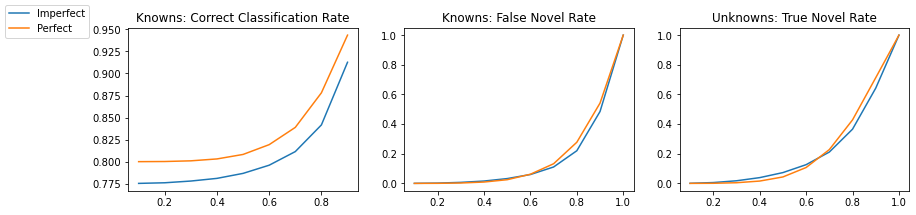

In [8]:
import matplotlib.pyplot as plt



fig = plt.figure(figsize = (14, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.title.set_text('Knowns: Correct Classification Rate')
ax2.title.set_text('Knowns: False Novel Rate')
ax3.title.set_text('Unknowns: True Novel Rate')

ax1.plot(thresholds, np.mean(imp_known_correct_all, axis = 0), label = 'Imperfect')
ax1.plot(thresholds, np.mean(per_known_correct_all, axis = 0), label = 'Perfect')


ax2.plot(thresholds, np.mean(imp_known_novel_all, axis = 0), label = 'Imperfect')
ax2.plot(thresholds, np.mean(per_known_novel_all, axis = 0), label = 'Perfect')

ax3.plot(thresholds, np.mean(imp_unknown_novel_all, axis = 0), label = 'Imperfect')
ax3.plot(thresholds, np.mean(per_unknown_novel_all, axis = 0), label = 'Perfect')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

plt.savefig('CNN_images_cf5_30iter.pdf')
plt.show()

In [20]:
#print(imp_known_correct_all)
print(imp_known_novel_all)
print(np.mean(imp_known_novel_all, axis = 0))

[[0.0, 0.0052, 0.0172, 0.0336, 0.0644, 0.1028, 0.1676, 0.2674, 0.4746, 1.0], [0.0012, 0.0032, 0.0074, 0.0166, 0.0334, 0.0616, 0.1064, 0.1992, 0.4296, 1.0], [0.0006, 0.0038, 0.0158, 0.032, 0.0608, 0.0984, 0.1676, 0.2828, 0.5314, 1.0], [0.0004, 0.0026, 0.0084, 0.0206, 0.047, 0.0838, 0.148, 0.2696, 0.489, 1.0], [0.0002, 0.002, 0.005, 0.0136, 0.0238, 0.0438, 0.0806, 0.1598, 0.3792, 1.0], [0.0002, 0.001, 0.0034, 0.008, 0.0154, 0.0344, 0.0806, 0.1892, 0.5002, 1.0], [0.0004, 0.002, 0.0058, 0.0148, 0.0304, 0.0674, 0.1312, 0.2716, 0.6212, 1.0], [0.0, 0.0012, 0.0036, 0.0102, 0.0184, 0.0348, 0.0686, 0.1416, 0.3188, 1.0], [0.0, 0.002, 0.0088, 0.0168, 0.0344, 0.0578, 0.1024, 0.2012, 0.4264, 1.0], [0.0, 0.0018, 0.0052, 0.012, 0.027, 0.0526, 0.097, 0.198, 0.4314, 1.0], [0.0002, 0.0008, 0.0044, 0.0084, 0.0186, 0.0364, 0.078, 0.1576, 0.3662, 1.0], [0.0004, 0.0024, 0.0092, 0.0216, 0.0456, 0.082, 0.1456, 0.2472, 0.4636, 1.0], [0.0, 0.0002, 0.002, 0.0056, 0.0144, 0.0296, 0.0668, 0.1838, 0.5132, 1.0], [0.0

In [25]:
print(x_train_known_imp)

[[0.         0.         2.316617   ... 0.         0.27032337 2.6178281 ]
 [3.09473    0.         3.9569597  ... 3.0561898  0.8326596  0.        ]
 [1.8025745  0.         0.         ... 1.2786716  0.         0.        ]
 ...
 [0.         3.7198727  0.         ... 3.797779   4.300847   0.        ]
 [2.1178799  0.         0.         ... 1.4942993  2.2446127  4.189491  ]
 [4.2678866  0.         0.9550949  ... 5.565894   1.4587125  0.        ]]


In [22]:
print(imp_known_novel)
print(imp_known_correct)

[0.0, 0.0004, 0.0028, 0.0084, 0.0222, 0.045, 0.0786, 0.162, 0.3842, 1.0]
[0.8204, 0.8207282913165266, 0.8221018852787806, 0.8247277127874143, 0.8306402127224382, 0.8391623036649215, 0.8476231821141741, 0.8704057279236277, 0.9324455992205262, nan]


In [23]:
print(imp_pred_known)

[[0.92141912 0.54474396 0.24720859 0.28102318 0.51982872]
 [0.3729681  0.72037704 0.94860999 0.31188523 0.35115612]
 [0.33518098 0.5835177  0.98197872 0.55761801 0.21944205]
 ...
 [0.50649221 0.75467576 0.1449165  0.90637229 0.3954678 ]
 [0.91778846 0.37357961 0.42675056 0.63112111 0.85997514]
 [0.44433764 0.75778691 0.18313878 0.89353345 0.43977949]]


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

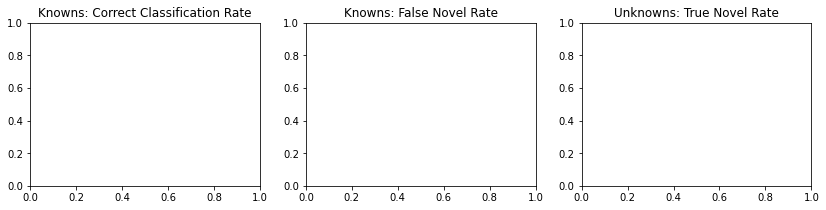

In [17]:
fig = plt.figure(figsize = (14, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.title.set_text('Knowns: Correct Classification Rate')
ax2.title.set_text('Knowns: False Novel Rate')
ax3.title.set_text('Unknowns: True Novel Rate')

ax1.plot(thresholds, len(imp_known_correct_all), label = 'Imperfect')
ax1.plot(thresholds, len(per_known_correct_all), label = 'Perfect')


ax2.plot(thresholds, len(imp_known_novel_all), label = 'Imperfect')
ax2.plot(thresholds, len(per_known_novel_all), label = 'Perfect')

ax3.plot(thresholds, len(imp_unknown_novel_all), label = 'Imperfect')
ax3.plot(thresholds, len(per_unknown_novel_all), label = 'Perfect')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

#plt.savefig('CNN_images_cf5_30iter.pdf')
plt.show()